In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the datasets
processed_air_quality_data = pd.read_csv('processed_air_quality_data.csv')
athens_data = pd.read_csv('athens_data.csv')

# Convert the date columns to datetime format
processed_air_quality_data['Date'] = pd.to_datetime(processed_air_quality_data['Date'])
athens_data['Date'] = pd.to_datetime(athens_data['Date'])

# Merge datasets on Date, Latitude, and Longitude
merged_data = pd.merge(processed_air_quality_data, athens_data, how='inner', on=['Date', 'Latitude', 'Longitude'])

# Handle missing values
merged_data.fillna(merged_data.mean(), inplace=True)

# Display the first few rows of the merged dataset as a table
from IPython.display import display
print("Sample of Merged Data:")
display(merged_data.head().style.background_gradient(cmap='viridis'))


<ipython-input-3-10353c769ee1>:22: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  merged_data.fillna(merged_data.mean(), inplace=True)


Sample of Merged Data:


,Date,id_x,Latitude,Longitude,Wind_Speed_U,Wind_Speed_V,Dewpoint_Temp,Soil_Temp,Precipitation,Vegetation_High,Vegetation_Low,Temp_x,Relative_Humidity,PM10_x,PM2_5,NO2_x,O3_x,AQI,station_name,Wind-Speed (U),Wind-Speed (V),Dewpoint Temp,Soil Temp,Total Percipitation,Vegitation (High),Vegitation (Low),Temp_y,Relative Humidity,PM10_y,PM2.5,NO2_y,O3_y,code,id_y
0,2020-05-01 00:00:00,9,37.978000,23.727000,2.066890,0.506321,9.382786,18.591980,0.000081,1.056027,1.017382,19.429079,55.691429,44.714286,25.714286,29.476190,10.809524,44.714286,ATHINAS,1.941428,-0.999548,10.683342,18.271925,0.000041,1.056650,1.017622,13.887849,81.121429,229.000000,131.000000,20.962398,58.865256,GR0027A,9
1,2020-05-01 00:00:00,10,37.988000,23.728000,2.059183,0.315882,9.598353,18.583782,0.000114,0.946851,0.960796,18.690502,59.372910,63.000000,39.250000,40.583333,15.682223,64.939655,ARISTOTELOUS,1.945101,-1.013354,10.750844,18.336251,0.000041,0.946851,0.961039,13.880884,81.508811,229.000000,131.000000,71.000000,49.682840,GR0003A,10
2,2020-05-01 00:00:00,11,38.031000,23.787000,1.940046,0.489833,8.875933,17.897435,0.000154,1.494257,1.085429,18.462492,57.462458,33.833333,9.026769,22.875000,37.875000,37.875000,MAROUSI,1.779847,-0.812353,9.910889,17.663021,0.000045,1.494257,1.085746,13.720817,77.883266,131.000000,10.683514,53.000000,1.000000,GR0022A,11
3,2020-05-01 00:00:00,12,38.021000,23.688000,2.077056,0.277844,9.724084,18.690558,0.000099,0.794767,0.925291,18.696419,59.888969,60.041667,8.058461,26.125000,76.591351,76.591351,PERISTERI,1.952669,-1.039560,10.920582,18.440717,0.000042,0.794767,0.925538,13.797412,82.832372,300.000000,9.954234,46.000000,63.666874,GR0028A,12
4,2020-05-01 00:00:00,15,37.932000,23.713000,1.992700,0.268830,9.202743,18.156711,0.000188,1.585302,1.396968,18.513779,58.375467,30.166667,8.796987,37.541667,76.655856,76.655856,SMYRNI,1.906065,-0.899416,10.325644,17.910115,0.000039,1.585302,1.397175,13.801415,79.693548,89.000000,10.469307,65.000000,49.682840,GR0031A,15


In [4]:
# Columns to drop if they exist
columns_to_drop = ['AQI', 'Date', 'station_name', 'code', 'id']

# Check if columns exist before dropping
existing_columns_to_drop = [col for col in columns_to_drop if col in merged_data.columns]

# Select features and target variable
features = merged_data.drop(columns=existing_columns_to_drop)
target = merged_data['AQI']

# Display the features before scaling
print("Features DataFrame Before Scaling:")
display(features.head().style.background_gradient(cmap='coolwarm'))

# Ensure features dataframe is not empty
if features.empty:
    raise ValueError("The features dataframe is empty. Please check the columns being dropped.")

# Scale features and target
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target.values.reshape(-1, 1))


Features DataFrame Before Scaling:


,id_x,Latitude,Longitude,Wind_Speed_U,Wind_Speed_V,Dewpoint_Temp,Soil_Temp,Precipitation,Vegetation_High,Vegetation_Low,Temp_x,Relative_Humidity,PM10_x,PM2_5,NO2_x,O3_x,Wind-Speed (U),Wind-Speed (V),Dewpoint Temp,Soil Temp,Total Percipitation,Vegitation (High),Vegitation (Low),Temp_y,Relative Humidity,PM10_y,PM2.5,NO2_y,O3_y,id_y
0,9,37.978000,23.727000,2.066890,0.506321,9.382786,18.591980,0.000081,1.056027,1.017382,19.429079,55.691429,44.714286,25.714286,29.476190,10.809524,1.941428,-0.999548,10.683342,18.271925,0.000041,1.056650,1.017622,13.887849,81.121429,229.000000,131.000000,20.962398,58.865256,9
1,10,37.988000,23.728000,2.059183,0.315882,9.598353,18.583782,0.000114,0.946851,0.960796,18.690502,59.372910,63.000000,39.250000,40.583333,15.682223,1.945101,-1.013354,10.750844,18.336251,0.000041,0.946851,0.961039,13.880884,81.508811,229.000000,131.000000,71.000000,49.682840,10
2,11,38.031000,23.787000,1.940046,0.489833,8.875933,17.897435,0.000154,1.494257,1.085429,18.462492,57.462458,33.833333,9.026769,22.875000,37.875000,1.779847,-0.812353,9.910889,17.663021,0.000045,1.494257,1.085746,13.720817,77.883266,131.000000,10.683514,53.000000,1.000000,11
3,12,38.021000,23.688000,2.077056,0.277844,9.724084,18.690558,0.000099,0.794767,0.925291,18.696419,59.888969,60.041667,8.058461,26.125000,76.591351,1.952669,-1.039560,10.920582,18.440717,0.000042,0.794767,0.925538,13.797412,82.832372,300.000000,9.954234,46.000000,63.666874,12
4,15,37.932000,23.713000,1.992700,0.268830,9.202743,18.156711,0.000188,1.585302,1.396968,18.513779,58.375467,30.166667,8.796987,37.541667,76.655856,1.906065,-0.899416,10.325644,17.910115,0.000039,1.585302,1.397175,13.801415,79.693548,89.000000,10.469307,65.000000,49.682840,15


In [5]:
# Reshape data for LSTM
time_steps = 30
X, y = [], []
for i in range(len(scaled_features) - time_steps):
    X.append(scaled_features[i:i + time_steps])
    y.append(scaled_target[i + time_steps])

X, y = np.array(X), np.array(y)

# Check the shape of X and y
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


Shape of X: (65749, 30, 30)
Shape of y: (65749, 1)


In [6]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
1644/1644 [==============================] - 28s 16ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 2/20
1644/1644 [==============================] - 26s 16ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/20
1644/1644 [==============================] - 25s 15ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 4/20
1644/1644 [==============================] - 26s 16ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/20
1644/1644 [==============================] - 26s 16ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 6/20
1644/1644 [==============================] - 25s 15ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/20
1644/1644 [==============================] - 25s 15ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 8/20
1644/1644 [==============================] - 27s 17ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/20
1644/1644 [==============================] - 26s 16ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/20
1644/1644 [==============================] - 24s 15m

In [7]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict AQI values
predicted_aqi = model.predict(X_test)
predicted_aqi = target_scaler.inverse_transform(predicted_aqi)
actual_aqi = target_scaler.inverse_transform(y_test)

# Calculate MSE and R-squared
mse = mean_squared_error(actual_aqi, predicted_aqi)
r2 = r2_score(actual_aqi, predicted_aqi)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²) Score: {r2}')


411/411 [==============================] - 2s 4ms/step - loss: 0.0011
Test Loss: 0.001075613428838551
Mean Squared Error (MSE): 170.40824875976543
R-squared (R²) Score: 0.4503433181915002


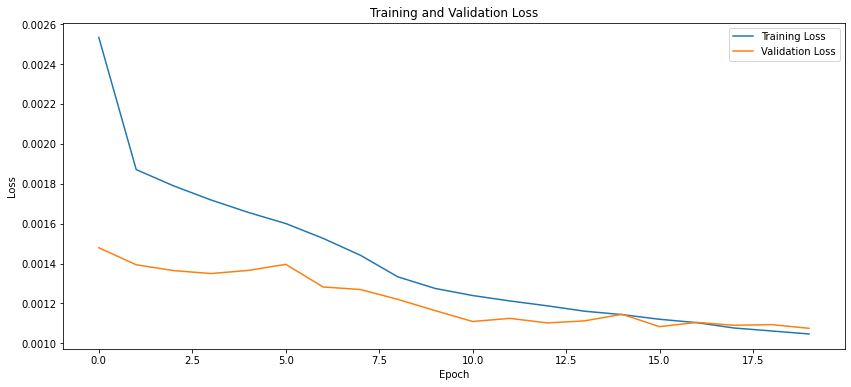

In [8]:
# Plot training and validation loss
plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


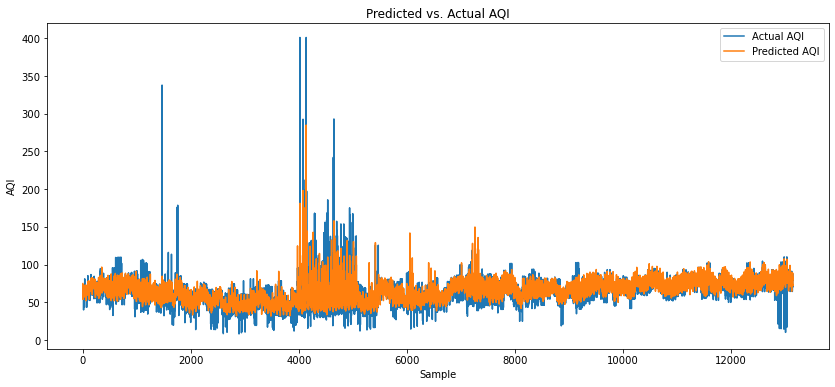

In [9]:
# Plot predicted vs. actual AQI values
plt.figure(figsize=(14, 6))
plt.plot(actual_aqi, label='Actual AQI')
plt.plot(predicted_aqi, label='Predicted AQI')
plt.title('Predicted vs. Actual AQI')
plt.xlabel('Sample')
plt.ylabel('AQI')
plt.legend()
plt.show()


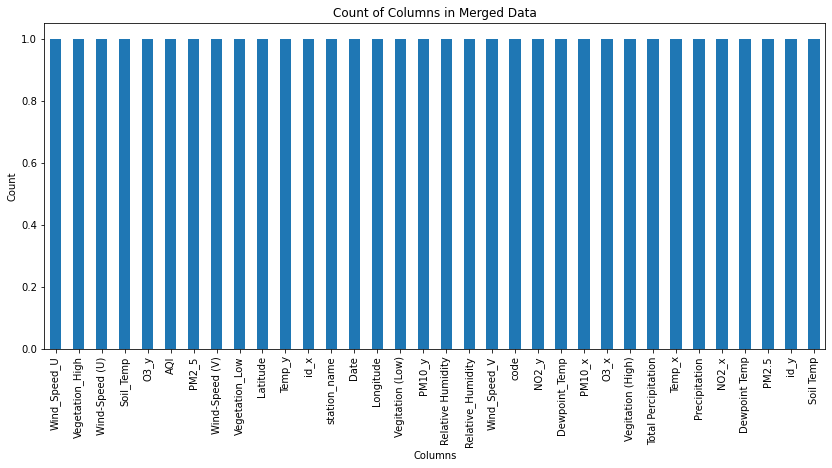

In [10]:
# Plotting the count of each feature
plt.figure(figsize=(14, 6))
merged_data.columns.value_counts().plot(kind='bar')
plt.title('Count of Columns in Merged Data')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.show()


<Figure size 1008x432 with 0 Axes>

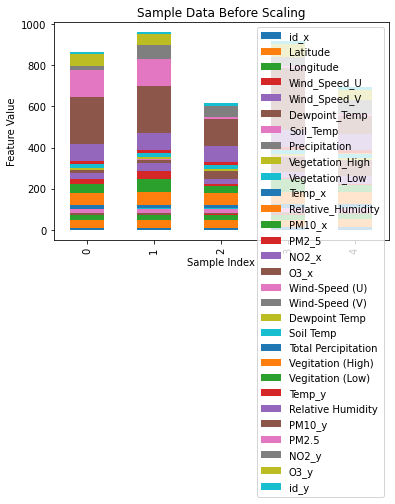

In [11]:
# Visualize the first few rows of features dataframe
plt.figure(figsize=(14, 6))
pd.DataFrame(features.head()).plot(kind='bar', stacked=True)
plt.title('Sample Data Before Scaling')
plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
plt.show()
